# Time Series Analysis
**Short-term temperature forecoast**

- understand the purpose of Time Series Analysis
- understand the concept of **time dependence** in time series data
- understand how to use AR and ARIMA models in order to predict the future

Checklist
- read a temperature curve
- decompose the time series
- train a linear model
- try other forecasting methods
- calculate quality metrics
- download more data
- plot climate data on a map

## 1. Download and read the data

- Go to www.ecad.eu
- Go to “Daily data”
- Click on “Custom query (ASCII)”
- Pick:
    - Type of series: blend
    - Country: Germany
    - Location: Berlin-Tempelhof
    - Element: Mean temperature


- read the data into a dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

df = pd.read_csv('data/ECA_blended_custom/TG_STAID002759_descr_removed.txt') # , header=0, sep=',', quotechar='"'
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,22,0
1,127488,18760102,25,0
2,127488,18760103,3,0
3,127488,18760104,-58,0
4,127488,18760105,-98,0


In [3]:
df.info() # whitespaces in column names

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52808 entries, 0 to 52807
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0    SOUID    52808 non-null  int64
 1       DATE  52808 non-null  int64
 2      TG     52808 non-null  int64
 3    Q_TG     52808 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


In [4]:
df.loc[0]

 SOUID        127488
    DATE    18760101
   TG             22
 Q_TG              0
Name: 0, dtype: int64

In [5]:
# remove whitespaces in df
df = df.rename(columns=lambda x: x.strip())

In [6]:
df.loc[0]

SOUID      127488
DATE     18760101
TG             22
Q_TG            0
Name: 0, dtype: int64

In [7]:
# temperature (TG) is in unit of the temperature is 0.1 °C (multiplied by 10,
# so that all values are integers, was important back than to save expensive data storage cost)
# convert the temperature into unit of 1°C 
df['TG'] = df['TG']/10
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,2.2,0
1,127488,18760102,2.5,0
2,127488,18760103,0.3,0
3,127488,18760104,-5.8,0
4,127488,18760105,-9.8,0


**The temperature T in Kelvin (K) is equal to the temperature T in degrees Celsius (°C) plus 273.15:**

$T(K) = T(°C) + 273.15$

In [8]:
# convert the temperature into Kelvin (because otherwise ....)
df['TG'] = df['TG'] + 273.15
df.head()

,SOUID,DATE,TG,Q_TG
0,127488,18760101,275.35,0
1,127488,18760102,275.65,0
2,127488,18760103,273.45,0
3,127488,18760104,267.35,0
4,127488,18760105,263.35,0


In [9]:
# format "DATE" column to datetime and set it as index 
df.set_index(pd.to_datetime(df['DATE'], format='%Y%m%d'), inplace=True)
df.head()

,SOUID,DATE,TG,Q_TG
DATE,,,,
1876-01-01,127488,18760101,275.35,0
1876-01-02,127488,18760102,275.65,0
1876-01-03,127488,18760103,273.45,0
1876-01-04,127488,18760104,267.35,0
1876-01-05,127488,18760105,263.35,0


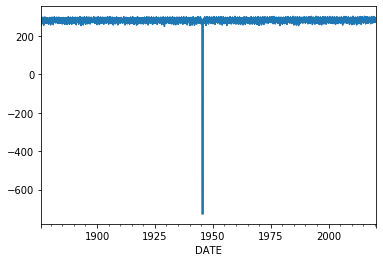

In [10]:
# plot the raw temperature data
df['TG'].plot()

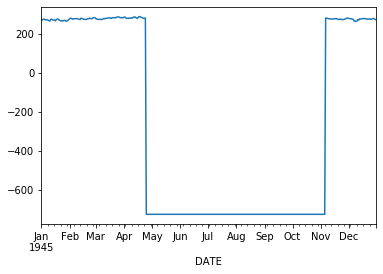

In [11]:
# zoom in the outlier area:
df.loc['1945-01-01':'1945-12-31', 'TG'].plot() # may to november 1945 the same value

In [27]:
df_year_1945 = df.loc['1945-01-01':'1945-12-31']
df_year_1944 = df.loc['1944-01-01':'1944-12-31']
df_year_1946 = df.loc['1946-01-01':'1946-12-31']

for row in df_year_1945.itertuples():
    temp = row[3]
    if temp == -9999:
        temp_44 = df_year_1944.at[(row.Index - pd.DateOffset(years=1), 'TG')]
        temp_46 = df_year_1946.at[(row.Index + pd.DateOffset(years=1), 'TG')]
        mean = (temp_44 + temp_46) / 2
        df.at[row.Index, 'TG'] = mean

print(df.loc['1945-04-25':'1945-05-15'])

             SOUID      DATE      TG  Q_TG    diff       pct  month
DATE                                                               
1945-04-25  127488  19450425 -726.75     9 -1007.9 -3.584919      4
1945-04-26  127488  19450426 -726.75     9     0.0  0.000000      4
1945-04-27  127488  19450427 -726.75     9     0.0  0.000000      4
1945-04-28  127488  19450428 -726.75     9     0.0  0.000000      4
1945-04-29  127488  19450429 -726.75     9     0.0  0.000000      4
1945-04-30  127488  19450430 -726.75     9     0.0  0.000000      4
1945-05-01  127488  19450501 -726.75     9     0.0  0.000000      5
1945-05-02  127488  19450502 -726.75     9     0.0  0.000000      5
1945-05-03  127488  19450503 -726.75     9     0.0  0.000000      5
1945-05-04  127488  19450504 -726.75     9     0.0  0.000000      5
1945-05-05  127488  19450505 -726.75     9     0.0  0.000000      5
1945-05-06  127488  19450506 -726.75     9     0.0  0.000000      5
1945-05-07  127488  19450507 -726.75     9     0

In [13]:
# other solution specific to the subset of missing values:
# df2 = df[df["TG"] == -9999]
# df2["TG"] = (df["1944-04-25" : "1944-11-05"]["TG"].array + df["1946-04-25" : "1946-11-05"]["TG"].array)/2
# df[df["TG"] == -9999] = df2

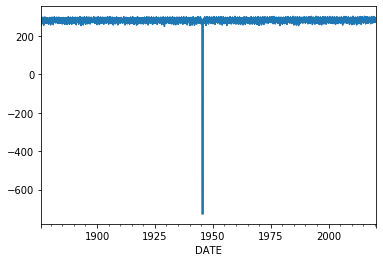

In [14]:
df['TG'].plot()

### Decomposition:
y = trend + variance change + seasonality + X + noise 


### Differential: Trend

In [15]:
df['diff'] = df['TG'].diff() # differential
# just the difference between the previous and the current count

In [16]:
df['diff'].mean()

0.0003427575889560122

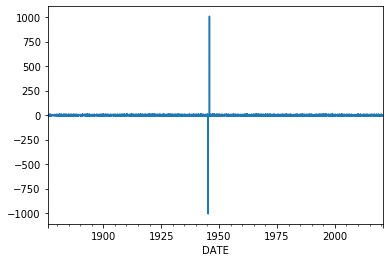

In [17]:
df['diff'].plot()

### Percentage change
removes trend and variance change

In [18]:
df['pct'] = df['TG'].pct_change()
df.head()

,SOUID,DATE,TG,Q_TG,diff,pct
DATE,,,,,,
1876-01-01,127488,18760101,275.35,0,NaN,NaN
1876-01-02,127488,18760102,275.65,0,0.3,0.001090
1876-01-03,127488,18760103,273.45,0,-2.2,-0.007981
1876-01-04,127488,18760104,267.35,0,-6.1,-0.022308
1876-01-05,127488,18760105,263.35,0,-4.0,-0.014962


In [19]:
# replace NaN with zeros?

In [20]:
df['pct'].mean()

-5.734826618050153e-05

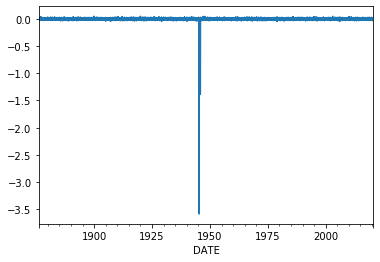

In [21]:
df['pct'].plot()

### Seasonality

In [22]:
# create month column from DATETIME index 
df['month'] = df.index.month
df.head()

,SOUID,DATE,TG,Q_TG,diff,pct,month
DATE,,,,,,,
1876-01-01,127488,18760101,275.35,0,NaN,NaN,1
1876-01-02,127488,18760102,275.65,0,0.3,0.001090,1
1876-01-03,127488,18760103,273.45,0,-2.2,-0.007981,1
1876-01-04,127488,18760104,267.35,0,-6.1,-0.022308,1
1876-01-05,127488,18760105,263.35,0,-4.0,-0.014962,1


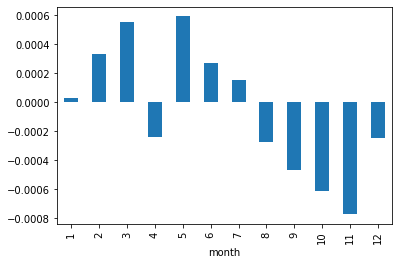

In [23]:
# monthly means
mm = df.groupby('month')['pct'].mean()
mm.plot.bar()

In [24]:
# we need a Series that is as long as our df
df.shape

(52808, 7)

In [25]:
mm.shape

(12,)

In [26]:
# cut off the last rows of the dataframe (after XX-12-31)
# to be able to create month_means column

# insert monthly mean value to the according month in the DF
# for i len(data frame col):
    for col[i] == i # get the value of the row
    access first (0) element in the list of mm
    insert this value in new column monthly means
    increase the value by 1 

#df_year_1945 = df.loc['1945-01-01':'1945-12-31']
df_cut_2019 = df.loc[:'2019-12-31']
df_cut_2019.head(20)

IndentationError: unexpected indent (<ipython-input-26-27a84fcfd4c6>, line 6)

In [ ]:
df_cut_2019.shape

In [ ]:
df['month_means'] = list(mm) * 12

In [ ]:
df['detrend_div'] = df['pct'] / df['month_means']
df['detrend_div'].plot() # identifies outliers
df['detrend_div'].mean()
df['detrend_div'].hist(bins=20)#

In [ ]:
df['detrend_sub'] = df['pct'] - df['month_means']
df['detrend_sub'].hist(bins=20) # subtraction is more robust

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# additive == diff
x = seasonal_decompose(df['TG'])
plot = x.plot() 

In [ ]:
# # multiplicative == diff
# x2 = seasonal_decompose(df['TG'], model='multiplicative')
# plot2 = x2.plot()
# # Multiplicative seasonality is not appropriate for zero and negative values